In [ ]:
!pip install sentence-transformers transformers datasets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.2

In [ ]:
from sentence_transformers import SentenceTransformer

model_name = "BAAI/bge-small-en-v1.5"

model = SentenceTransformer(
    model_name,
    trust_remote_code=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator
import pandas as pd
import os

# 3. Load a dataset to finetune on
dataset = load_dataset("arulpm/reposight", "triplet")
train_dataset = dataset["train"]
eval_dataset = dataset["dev"]
test_dataset = dataset["test"]

# 4. Define a loss function
loss = MultipleNegativesRankingLoss(model)

os.makedirs(f"{model_name}", exist_ok=True)
# 5. (Optional) Specify training arguments
args = SentenceTransformerTrainingArguments(
    output_dir=f"{model_name}",
    num_train_epochs=10,
    per_device_train_batch_size=8,  # Increased from 2
    per_device_eval_batch_size=8,  # Increased from 2
    gradient_accumulation_steps=2,  # Added gradient accumulation
    warmup_ratio=0.1,
    fp16=False,  # Disabled fp16
    bf16=True,  # Enabled bf16 (if supported by your GPU)
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=f"{model_name}_2-all-nli-triplet",
)

# 6. (Optional) Create an evaluator & evaluate the base model
dev_evaluator = TripletEvaluator(
    anchors=eval_dataset["anchor"],
    positives=eval_dataset["positive"],
    negatives=eval_dataset["negative"],
    name="all-nli-dev",
)
dev_evaluator(model)

# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()

# (Optional) Evaluate the trained model on the test set, after training completes
test_evaluator = TripletEvaluator(
    anchors=test_dataset["anchor"],
    positives=test_dataset["positive"],
    negatives=test_dataset["negative"],
    name="all-nli-test",
)
print(test_evaluator(model))

os.makedirs(f"model/{model_name}/", exist_ok=True)

# 8. Save the trained model
model.save_pretrained(f"model/{model_name}/")




Step,Training Loss,Validation Loss,All-nli-dev Cosine Accuracy
100,0.008900,0.204000,1.000000
200,0.103300,0.157997,1.000000
300,0.061400,0.165776,1.000000
400,0.051800,0.191477,1.000000
500,0.026600,0.153589,1.000000
600,0.010700,0.150500,1.000000
700,0.010700,0.149608,1.000000
800,0.004900,0.157553,1.000000
900,0.003800,0.163100,1.000000
1000,0.002500,0.175783,1.000000


{'all-nli-test_cosine_accuracy': 1.0}


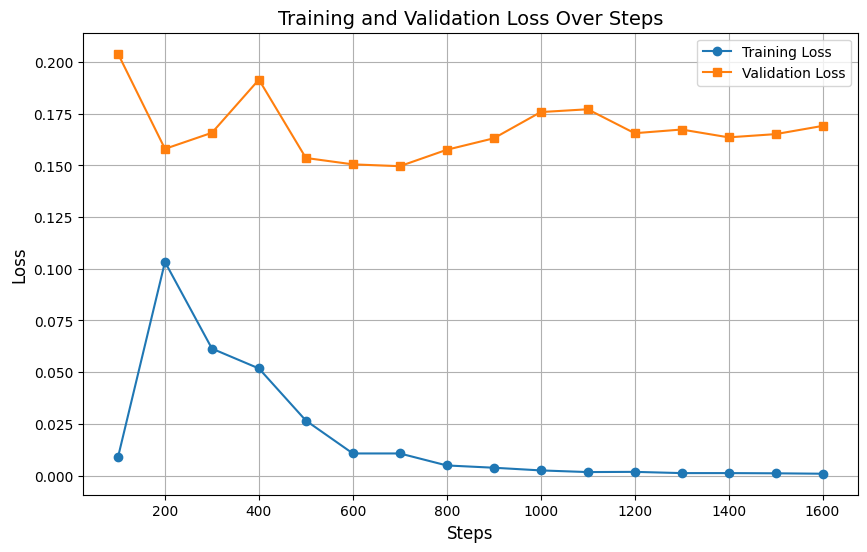

In [ ]:
import matplotlib.pyplot as plt

# Data from the training log
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]
training_loss = [0.008900, 0.103300, 0.061400, 0.051800, 0.026600, 0.010700, 0.010700, 0.004900,
                 0.003800, 0.002500, 0.001700, 0.001800, 0.001200, 0.001200, 0.001100, 0.000900]
validation_loss = [0.204000, 0.157997, 0.165776, 0.191477, 0.153589, 0.150500, 0.149608, 0.157553,
                   0.163100, 0.175783, 0.177136, 0.165561, 0.167344, 0.163559, 0.165117, 0.169089]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='s')

# Labels and Title
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Steps', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import shutil

# To zip a folder
# Replace 'folder_to_zip' with your folder name and 'output.zip' with desired zip file name
shutil.make_archive('output', 'zip', 'folder_to_zip')

# Alternatively, if you need more control, you can use zipfile module:
import zipfile
import os

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Usage
zip_folder('/content/model', 'model.zip')